## Uso de Dropout en Regresión


<h3>Objetivo de este Notebook</h3>
<h5>1. Crear el modelo y la función de costo al estilo PyTorch.</h5>
<h5>2. Aprender Descenso de Gradiente por Lotes (Batch Gradient Descent).</h5>


In [1]:
# Import the libraries we need for the lab

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)

### Genera algunos datos

Crea la clase del conjunto de datos polinómico:


In [2]:
# Create Data object

class Data(Dataset):

    # Constructor
    def __init__(self, N_SAMPLES=40, noise_std=1, train=True):
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        self.f = self.x ** 2
        if train != True:
            torch.manual_seed(1)
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
        else:
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        return self.len

    # Plot the data
    def plot(self):
        plt.figure(figsize = (6.1, 10))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy() ,label="True Function", color='orange')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

Crea un objeto del conjunto de datos:


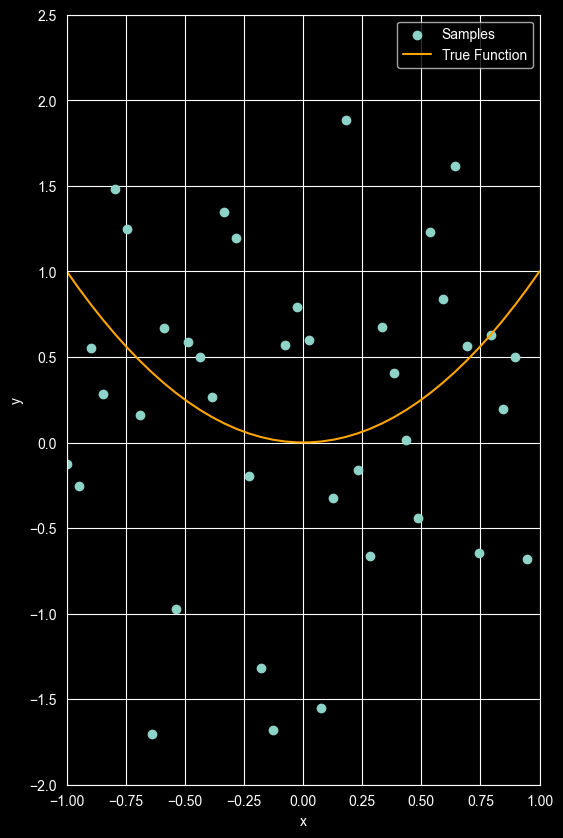

In [3]:
# Create the dataset object and plot the dataset

data_set = Data()
data_set.plot()

Obtén algunos datos de validación:


In [4]:
# Create validation dataset object

validation_set = Data(train=False)

Crea el Modelo, el Optimizador y la Función de Pérdida Total (Costo)


Crea un módulo personalizado con tres capas. in_size es el tamaño de las características de entrada, n_hidden es el tamaño de las capas ocultas y out_size es el tamaño de la salida. p es la probabilidad de *dropout*. El valor predeterminado es 0, lo que significa que no hay *dropout*.


In [5]:
# Create the class for model

class Net(nn.Module):

    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)

    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

Crea dos objetos de modelo: model sin *dropout* y model_drop con una probabilidad de *dropout* de 0.5:


In [6]:
# Create the model objects

model = Net(1, 300, 1)
model_drop = Net(1, 300, 1, p=0.5)

### Entrena el modelo mediante Descenso de Gradiente por Mini-Lotes (Mini-Batch Gradient Descent)


Establece el modelo con *dropout* en modo de entrenamiento; este es el modo predeterminado, pero es una buena práctica hacerlo explícitamente.


In [7]:
# Set the model to train mode

model_drop.train()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

Entrena el modelo usando el optimizador Adam. Consulta la unidad sobre otros optimizadores. Utiliza la pérdida de error cuadrático medio (MSE):


In [8]:
# Set the optimizer and criterion function

optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

Inicializa un diccionario que almacene la pérdida de entrenamiento y validación para cada modelo:


In [9]:
# Initialize the dict to contain the loss results

LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

Ejecuta 500 iteraciones de descenso de gradiente por lotes:


In [10]:
# Train the model

epochs = 500

def train_model(epochs):
    for epoch in range(epochs):
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        #store the loss for  both the training and validation  data for both models
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()

train_model(epochs)

Establece el modelo con *dropout* en modo de evaluación:


In [11]:
# Set the model with dropout to evaluation mode

model_drop.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

Realiza una predicción utilizando ambos modelos:


In [12]:
# Make the prediction

yhat = model(data_set.x)
yhat_drop = model_drop(data_set.x)

Grafica las predicciones de ambos modelos. Compáralas con los puntos de entrenamiento y la función real:

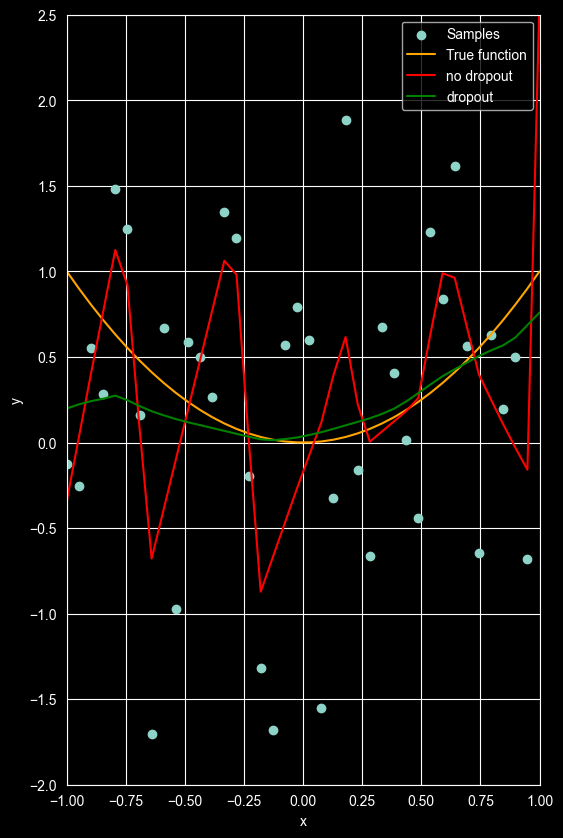

In [13]:
# Plot the predictions for both models

plt.figure(figsize=(6.1, 10))

plt.scatter(data_set.x.numpy(), data_set.y.numpy(), label="Samples")
plt.plot(data_set.x.numpy(), data_set.f.numpy(), label="True function", color='orange')
plt.plot(data_set.x.numpy(), yhat.detach().numpy(), label='no dropout', c='r')
plt.plot(data_set.x.numpy(), yhat_drop.detach().numpy(), label="dropout", c ='g')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

Puedes observar que el modelo que utiliza *dropout* sigue mejor la función que generó los datos. Usamos el logaritmo para hacer más evidente la diferencia.


Grafica la pérdida de entrenamiento y validación para ambos modelos:


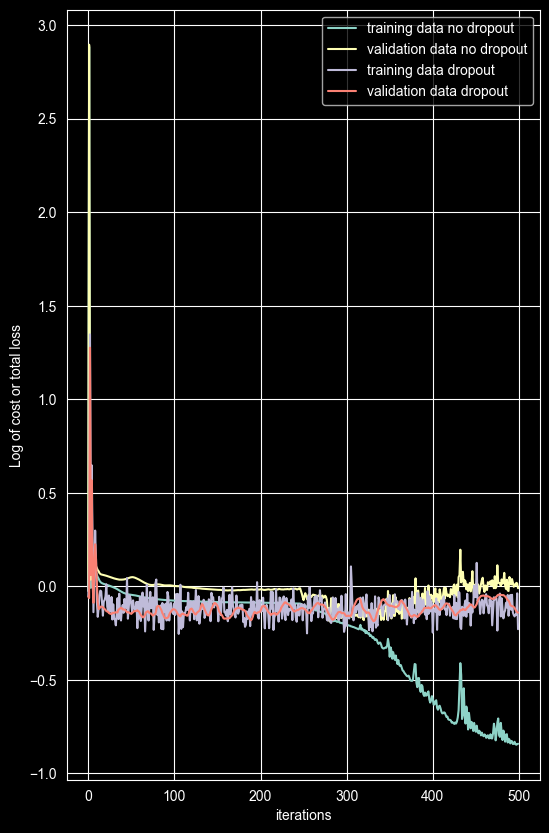

In [14]:
# Plot the loss

plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)), label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")

Observa que el modelo sin *dropout* se desempeña mejor en los datos de entrenamiento, pero peor en los datos de validación. Esto sugiere **sobreajuste (overfitting)**.

Sin embargo, el modelo que utiliza *dropout* se desempeña mejor en los datos de validación, aunque peor en los datos de entrenamiento.
